# Самостоятельный проект

## Тема проекта: рекомендательная система фильмов

## Суть проекта: Создания модели для рекомендации фильмов, в зависимости от комментария

## План работы:
- #### Анализ исходных данных
- #### Предварительная обработка данных
- #### Состовление рекомендационных систем
- #### Создание API
- #### Создание приложение

### Подключение библиотек

In [33]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import re, pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

### Изменение настройки отображения чисел с плаваующей запятой

In [36]:
pd.set_option('display.float_format', '{:.3f}'.format)

### Загрузка датасета

In [39]:
movies = pd.read_csv('moveilens/movies.csv')

In [41]:
ratings = pd.read_csv('moveilens/ratings.csv')

## Анализ исходных данных

In [8]:
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [9]:
movies.shape

(87585, 3)

In [10]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87585 entries, 0 to 87584
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  87585 non-null  int64 
 1   title    87585 non-null  object
 2   genres   87585 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


In [11]:
movies.describe(include='all')

,movieId,title,genres
count,87585.000,87585,87585
unique,NaN,87382,1798
top,NaN,Alone (2020),Drama
freq,NaN,4,12443
mean,157651.366,NaN,NaN
std,79013.402,NaN,NaN
min,1.000,NaN,NaN
25%,112657.000,NaN,NaN
50%,165741.000,NaN,NaN
75%,213203.000,NaN,NaN


In [12]:
movies[movies.title.str.match(r'^[a-zA-Z0-9\s()]+$')]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama
87581,292737,Shelter in Solitude (2023),Comedy|Drama
87582,292753,Orca (2023),Drama
87583,292755,The Angry Breed (1968),Drama


In [13]:
movies[movies.genres.str.match('^[a-zA-Z|]+$')]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama
87581,292737,Shelter in Solitude (2023),Comedy|Drama
87582,292753,Orca (2023),Drama
87583,292755,The Angry Breed (1968),Drama


### Описание набора данных

__movieId__ - уникальный идентификатор фильма

__title__ - название фильма

__genres__ - Жанры фильма

In [16]:
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,17,4.000,944249077
1,1,25,1.000,944250228
2,1,29,2.000,943230976
3,1,30,5.000,944249077
4,1,32,5.000,943228858
5,1,34,2.000,943228491
6,1,36,1.000,944249008
7,1,80,5.000,944248943
8,1,110,3.000,943231119
9,1,111,5.000,944249008


In [17]:
ratings.shape

(32000204, 4)

In [18]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000204 entries, 0 to 32000203
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 976.6 MB


In [19]:
ratings.describe()

,userId,movieId,rating,timestamp
count,32000204.000,32000204.000,32000204.000,32000204.000
mean,100278.506,29318.610,3.540,1275241199.573
std,57949.046,50958.161,1.059,256162975.951
min,1.000,1.000,0.500,789652004.000
25%,50053.000,1233.000,3.000,1051012430.000
50%,100297.000,3452.000,3.500,1272621812.500
75%,150451.000,44199.000,4.000,1503158345.250
max,200948.000,292757.000,5.000,1697164147.000


### Описание набора данных

__userId__ - уникальный идентификатор пользователя

__movieId__ - уникальный идентификатор фильма

__rating__ - рейнтинг фильма от пользователя(0,5 звезды - 5,0 звезды)

__timestamp__ - Временные метки представляют собой секунды с полуночи по всемирному координированному времени (UTC) 1 января 1970 года.

## Предварительная обработка данных

In [42]:
def change_title(text):
    return ' '.join(text.split()[:len(text.split()) - 1]), text.split()[len(text.split()) - 1][1:5]

In [43]:
movies[['title', 'year-production']] = pd.DataFrame(movies['title'].apply(change_title).to_list())

In [44]:
movies = movies[movies.title.str.match(r'^[a-zA-Z0-9\s()]+$')]

In [45]:
movies['genres'] = movies['genres'].apply(lambda text: text.split('|')[0])

In [46]:
movies = movies[(movies.genres.str.match(r'^[a-zA-Z]+$')) & (movies.genres != 'IMAX')]

In [47]:
movies.head(10)

,movieId,title,genres,year-production
0,1,Toy Story,Adventure,1995
1,2,Jumanji,Adventure,1995
2,3,Grumpier Old Men,Comedy,1995
3,4,Waiting to Exhale,Comedy,1995
4,5,Father of the Bride Part II,Comedy,1995
5,6,Heat,Action,1995
6,7,Sabrina,Comedy,1995
7,8,Tom and Huck,Adventure,1995
8,9,Sudden Death,Action,1995
9,10,GoldenEye,Action,1995


In [48]:
movies.genres.value_counts()

genres
Drama          15731
Comedy         12613
Action          6930
Documentary     5123
Horror          3878
Crime           2964
Adventure       2159
Animation       2071
Children        1570
Thriller        1237
Romance          639
Western          530
Mystery          446
Fantasy          381
War              100
Musical           69
Name: count, dtype: int64

In [49]:
movies.shape

(56441, 4)

In [50]:
ratings = ratings.drop('timestamp', axis=1)

In [51]:
ratings

,userId,movieId,rating
0,1,17,4.000
1,1,25,1.000
2,1,29,2.000
3,1,30,5.000
4,1,32,5.000
...,...,...,...
32000199,200948,79702,4.500
32000200,200948,79796,1.000
32000201,200948,80350,0.500
32000202,200948,80463,3.500


### Добавление своих оценок

In [53]:
userId = 222333

In [54]:
movieId = [123314,
 170283,
 176207,
 1344,
 277696,
 38881,
 136728,
 163286,
 131806,
 59333,
 183651,
 127585,
 195367,
 128864,
 142100,
 124637,
 44949,
 185439,
 195121,
 1053,
 225956,
 183611,
 195067,
 173987,
 144015,
 262513,
 227887,
 200496,
 83798,
 271182,
 203026,
 274591,
 189139,
 145160,
 230703,
 282311,
 130902,
 274781,
 222419,
 213662,
 278518,
 170959,
 123026,
 242744,
 137026,
 291346,
 169442,
 152256,
 137881,
 174413,
 218305,
 65263,
 5558,
 221764,
 333,
 144928,
 183367,
 93510,
 48127,
 143910,
 108271,
 72681,
 199450,
 136894,
 285827,
 106234,
 2213,
 7988,
 119663,
 132060,
 180313,
 65764,
 168924,
 158066,
 153160,
 162378,
 49110,
 178393,
 259619,
 2924,
 184539,
 178829,
 68157,
 157136,
 99117,
 167410,
 173521,
 229587,
 4863,
 177009,
 254648,
 289057,
 195593,
 168412,
 82313,
 150292,
 173501,
 205941,
 207255,
 206220]

In [55]:
rating = [2.5,
 0.5,
 2.0,
 5.0,
 2.5,
 3.5,
 3.0,
 4.0,
 1.5,
 2.5,
 4.0,
 1.5,
 1.5,
 4.0,
 1.0,
 2.5,
 4.0,
 5.0,
 5.0,
 1.0,
 2.0,
 1.0,
 2.5,
 3.5,
 3.5,
 4.0,
 1.5,
 3.5,
 4.5,
 4.0,
 2.0,
 1.5,
 4.5,
 1.5,
 3.0,
 3.5,
 2.0,
 4.0,
 2.5,
 4.0,
 3.0,
 2.5,
 0.5,
 1.0,
 2.0,
 3.0,
 3.5,
 1.0,
 5.0,
 4.0,
 2.0,
 1.0,
 4.5,
 3.0,
 3.5,
 0.5,
 5.0,
 3.0,
 2.5,
 5.0,
 4.0,
 1.0,
 4.0,
 3.5,
 2.5,
 4.5,
 3.0,
 4.0,
 4.5,
 4.5,
 5.0,
 4.0,
 1.0,
 1.5,
 4.0,
 4.5,
 5.0,
 1.0,
 3.5,
 4.0,
 1.0,
 2.5,
 1.0,
 3.0,
 3.5,
 2.5,
 1.5,
 5.0,
 2.5,
 2.0,
 1.5,
 5.0,
 3.5,
 1.0,
 4.5,
 3.5,
 4.5,
 1.0,
 2.5,
 1.0]

In [56]:
my_df = pd.DataFrame({'userId' : [userId for _ in range(100)], 'movieId' : movieId, 'rating' : rating})

In [57]:
my_df

,userId,movieId,rating
0,222333,123314,2.500
1,222333,170283,0.500
2,222333,176207,2.000
3,222333,1344,5.000
4,222333,277696,2.500
...,...,...,...
95,222333,150292,3.500
96,222333,173501,4.500
97,222333,205941,1.000
98,222333,207255,2.500


In [58]:
ratings = pd.concat([ratings, my_df])

In [59]:
ratings

,userId,movieId,rating
0,1,17,4.000
1,1,25,1.000
2,1,29,2.000
3,1,30,5.000
4,1,32,5.000
...,...,...,...
95,222333,150292,3.500
96,222333,173501,4.500
97,222333,205941,1.000
98,222333,207255,2.500


### Объединение датасета

In [61]:
df_films_reviews = ratings.merge(movies, on='movieId')

In [62]:
df_films_reviews.dropna(inplace=True)

In [63]:
df_films_reviews.head(10)

,userId,movieId,rating,title,genres,year-production
0,1,17,4.000,Sense and Sensibility,Drama,1995
1,1,25,1.000,Leaving Las Vegas,Drama,1995
2,1,30,5.000,Shanghai Triad (Yao a yao yao dao waipo qiao),Crime,1995
3,1,34,2.000,Babe,Children,1995
4,1,36,1.000,Dead Man Walking,Crime,1995
5,1,110,3.000,Braveheart,Action,1995
6,1,111,5.000,Taxi Driver,Crime,1976
7,1,161,1.000,Crimson Tide,Drama,1995
8,1,176,4.000,Living in Oblivion,Comedy,1995
9,1,223,3.000,Clerks,Comedy,1994


In [64]:
df_films_reviews.shape

(19160529, 6)

In [65]:
df_films_reviews

,userId,movieId,rating,title,genres,year-production
0,1,17,4.000,Sense and Sensibility,Drama,1995
1,1,25,1.000,Leaving Las Vegas,Drama,1995
2,1,30,5.000,Shanghai Triad (Yao a yao yao dao waipo qiao),Crime,1995
3,1,34,2.000,Babe,Children,1995
4,1,36,1.000,Dead Man Walking,Crime,1995
...,...,...,...,...,...,...
19160524,222333,150292,3.500,Blue and Not So Pink,Drama,2012
19160525,222333,173501,4.500,I am Jane Doe,Crime,2017
19160526,222333,205941,1.000,Back to School,Comedy,2019
19160527,222333,207255,2.500,The Great Journey,Drama,2004


### Сохранение датасета

In [1023]:
df_films_reviews.to_csv('dataset/df_films_reviews.csv')

## Состовление рекомендационных систем

### Система рекомендаций на основе взвешенных рейтингов

In [1049]:
def popularite_films():
    avg_ratings = df_films_reviews.groupby('title')['rating'].mean().reset_index().rename(columns={'rating': 'avg_rating'})
    avg = pd.DataFrame(avg_ratings).sort_values('avg_rating',ascending=False)
    cnt_ratings = df_films_reviews.groupby('title')['rating'].count().reset_index().rename(columns={'rating': 'count_rating'})
    cnt=pd.DataFrame(cnt_ratings).sort_values('count_rating',ascending=False)
    popularite=avg.merge(cnt,on='title')
    v=popularite["count_rating"]
    R=popularite["avg_rating"]
    m=v.quantile(0.90)
    c=R.mean()
    popularite['w_score']=((v*R) + (m*c)) / (v+m)
    return popularite.sort_values('w_score',ascending=False).head(10).reset_index()[['title', 'w_score']]

In [1050]:
df_popularite_films = popularite_films()
df_popularite_films

,title,w_score
0,Planet Earth,4.325
1,Band of Brothers,4.303
2,Planet Earth II,4.274
3,Parasite,4.257
4,12 Angry Men,4.239
5,Seven Samurai (Shichinin no samurai),4.230
6,Fight Club,4.225
7,Rear Window,4.213
8,Spirited Away (Sen to Chihiro no kamikakushi),4.204
9,Pulp Fiction,4.194


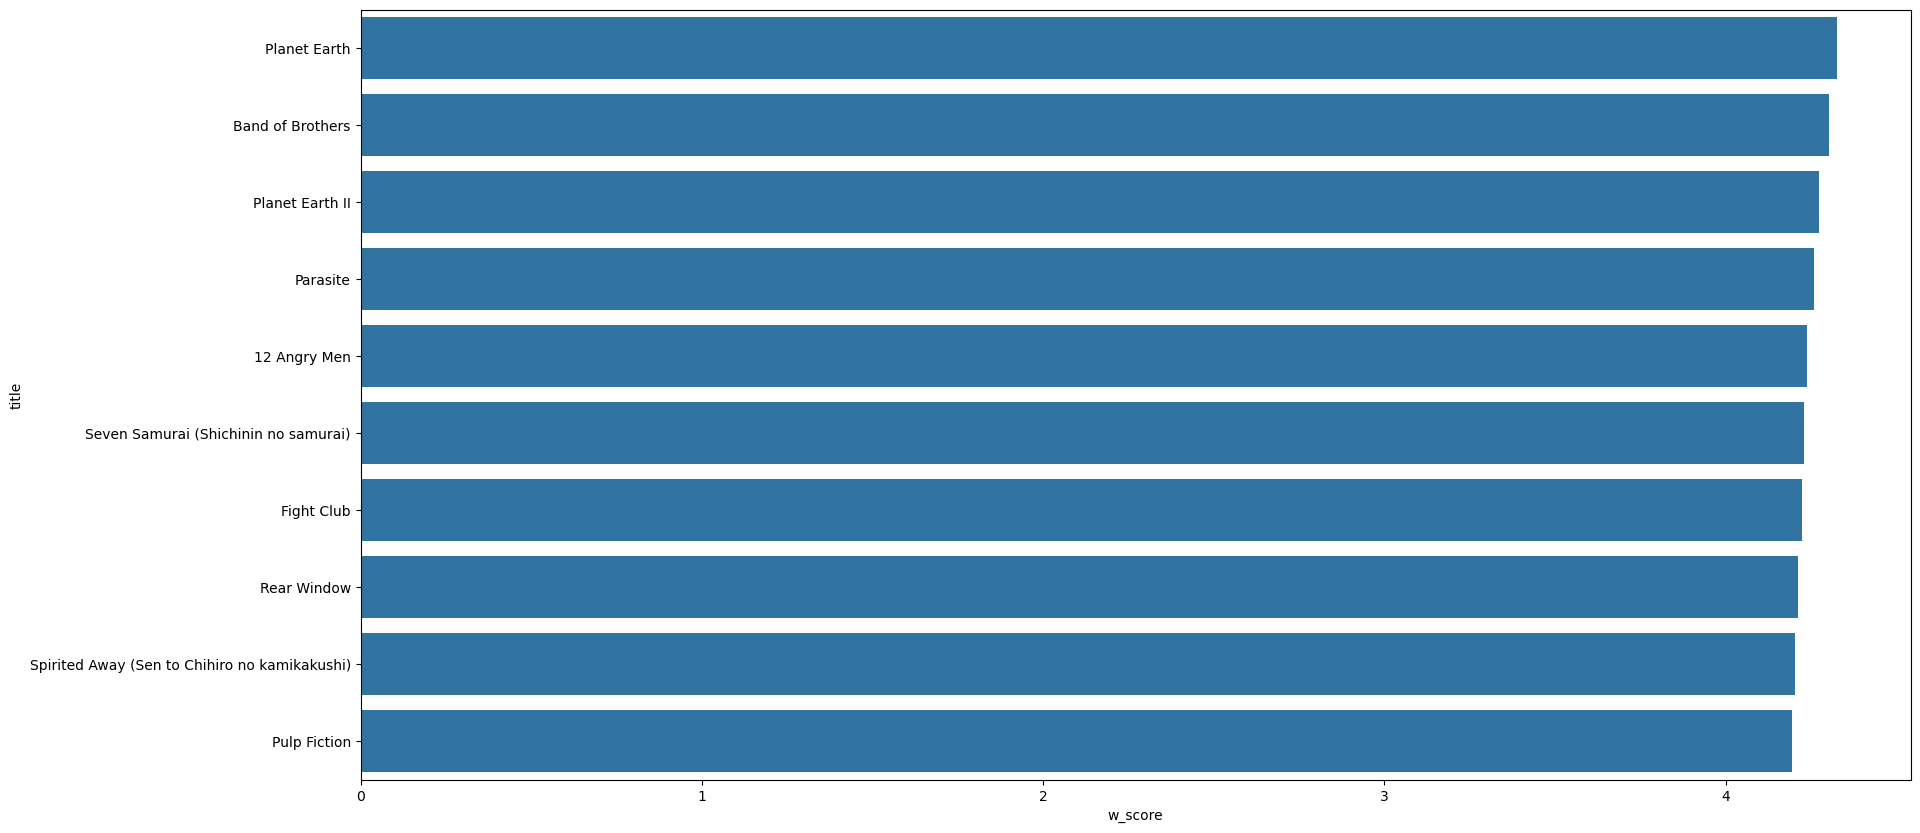

In [1051]:
plt.figure(figsize=(20, 10))
sns.barplot(x='w_score', y='title', data=df_popularite_films)
plt.show()

### Система рекомендаций по жанрам

In [1053]:
def popularite_films_by_genre(genre):
    df = df_films_reviews[df_films_reviews['genres'] == genre]
    avg_ratings = df.groupby('title')['rating'].mean().reset_index().rename(columns={'rating': 'avg_rating'})
    avg = pd.DataFrame(avg_ratings).sort_values('avg_rating',ascending=False)
    cnt_ratings = df.groupby('title')['rating'].count().reset_index().rename(columns={'rating': 'count_rating'})
    cnt=pd.DataFrame(cnt_ratings).sort_values('count_rating',ascending=False)
    popularite=avg.merge(cnt,on='title')
    v=popularite["count_rating"]
    R=popularite["avg_rating"]
    m=v.quantile(0.90)
    c=R.mean()
    popularite['w_score']=((v*R) + (m*c)) / (v+m)
    return popularite.sort_values('w_score',ascending=False).head(10).reset_index()[['title', 'w_score']]

In [1054]:
df_popularite_films_by_genre = popularite_films_by_genre('Drama')
df_popularite_films_by_genre

,title,w_score
0,12 Angry Men,4.254
1,Casablanca,4.187
2,Whiplash,4.143
3,Paths of Glory,4.138
4,All About Eve,4.125
5,To Kill a Mockingbird,4.123
6,Cinema Paradiso (Nuovo cinema Paradiso),4.110
7,Twin Peaks,4.110
8,Ran,4.107
9,Vertigo,4.106


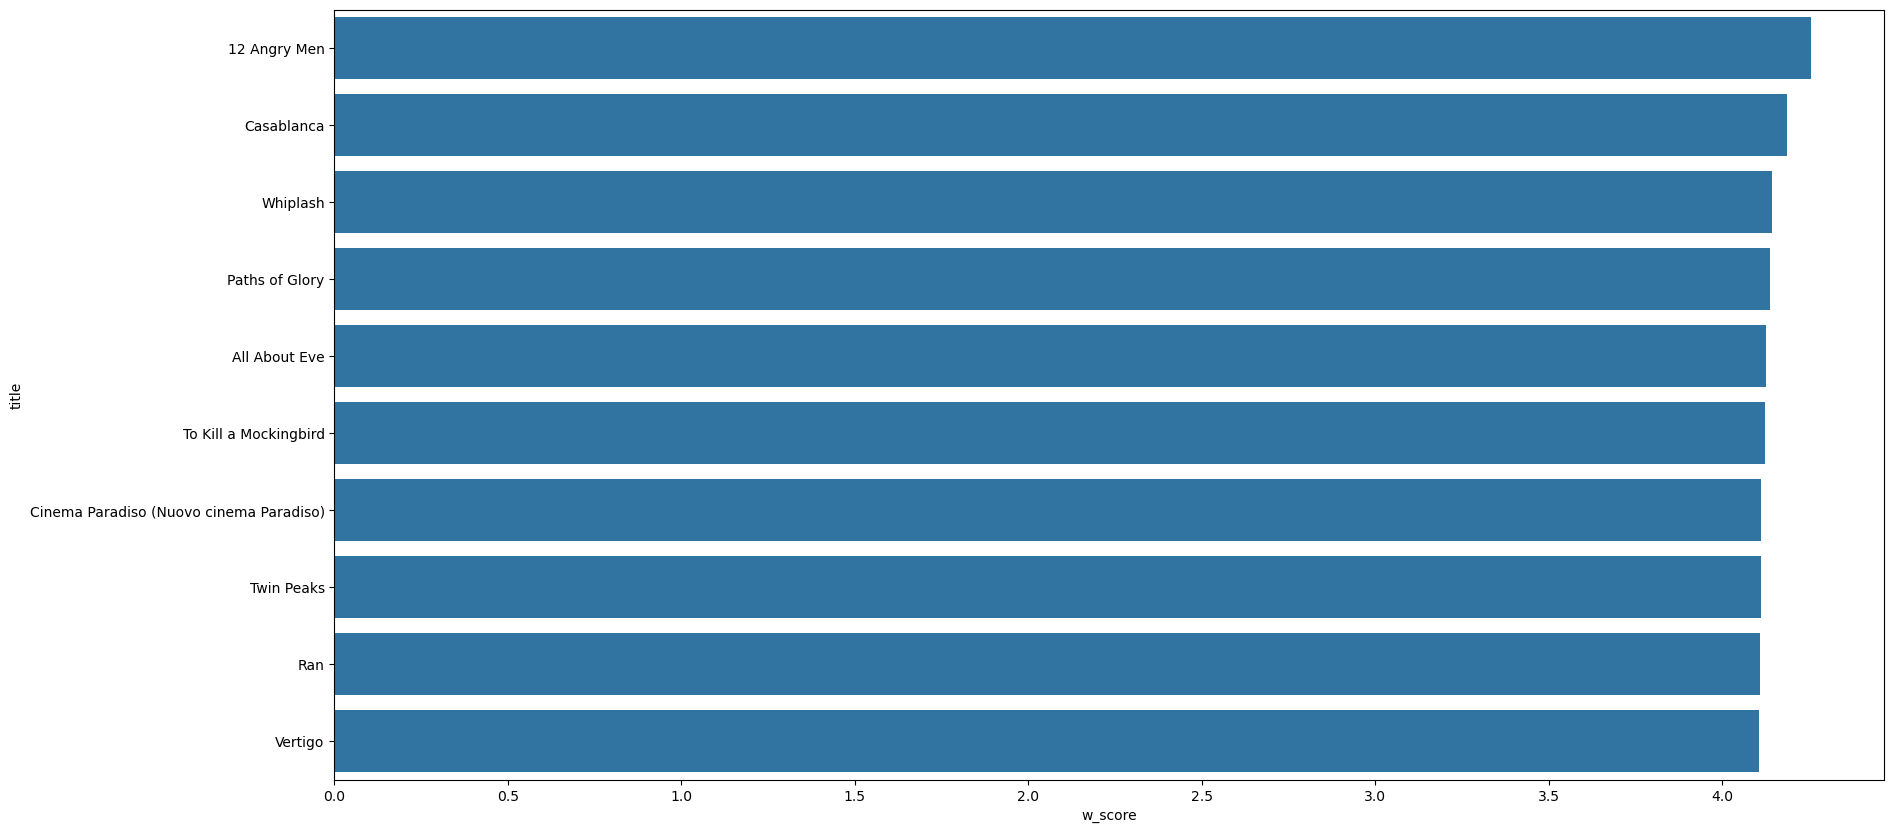

In [1055]:
plt.figure(figsize=(20, 10))
sns.barplot(x='w_score', y='title', data=df_popularite_films_by_genre)
plt.show()

In [1056]:
df_popularite_films_by_genre = popularite_films_by_genre('Comedy')
df_popularite_films_by_genre

,title,w_score
0,Parasite,4.269
1,Pulp Fiction,4.192
2,Fargo,4.109
3,Intouchables,4.095
4,Snatch,4.054
5,Forrest Gump,4.049
6,It Happened One Night,4.034
7,Some Like It Hot,4.018
8,Modern Times,4.013
9,Duck Soup,4.013


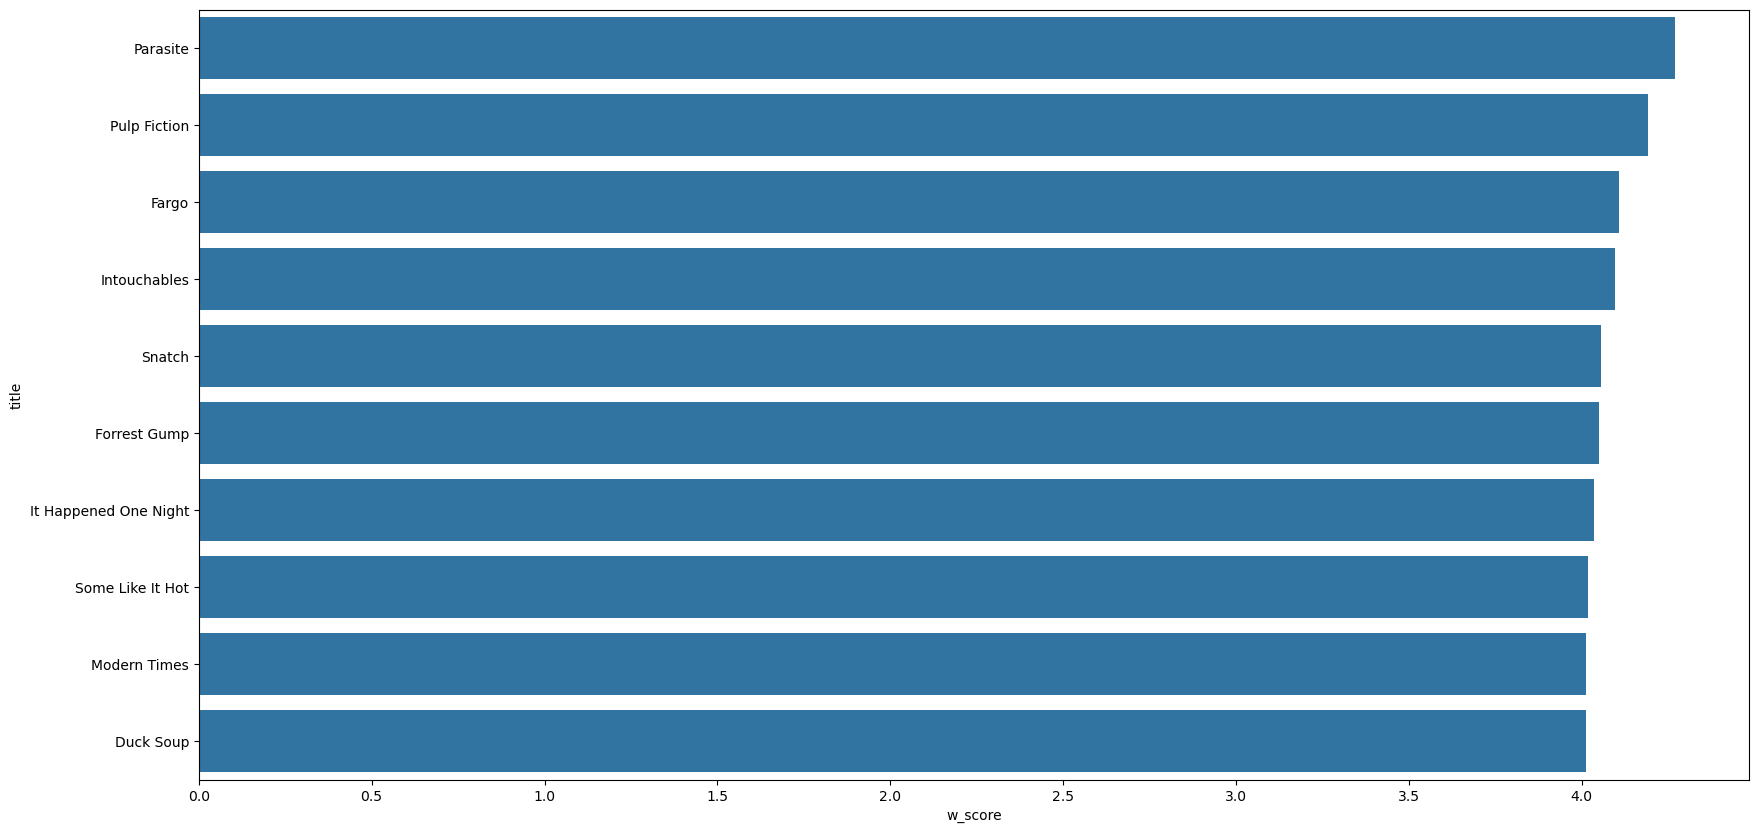

In [1057]:
plt.figure(figsize=(20, 10))
sns.barplot(x='w_score', y='title', data=df_popularite_films_by_genre)
plt.show()

In [1058]:
df_popularite_films_by_genre = popularite_films_by_genre('Action')
df_popularite_films_by_genre

,title,w_score
0,Fight Club,4.212
1,Seven Samurai (Shichinin no samurai),4.174
2,Inception,4.136
3,City of God (Cidade de Deus),4.132
4,North by Northwest,4.127
5,Raiders of the Lost Ark (Indiana Jones and the...,4.095
6,Blade Runner,4.085
7,Apocalypse Now,4.084
8,Band of Brothers,4.030
9,Saving Private Ryan,4.030


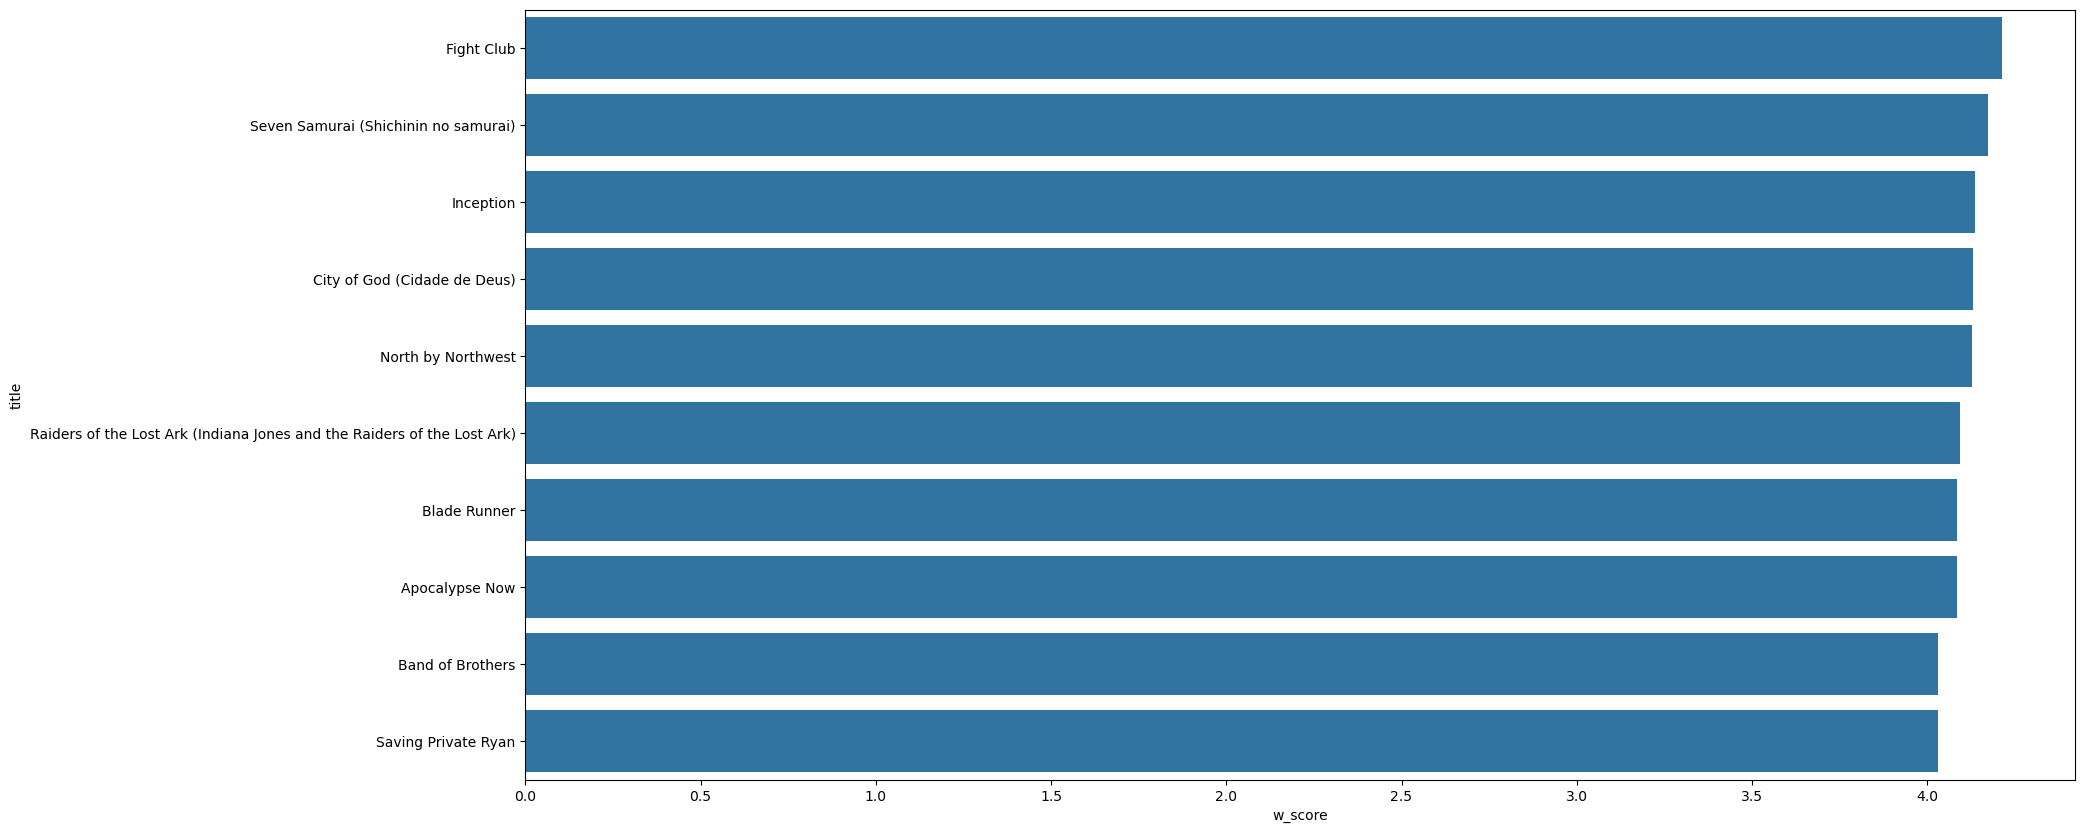

In [1059]:
plt.figure(figsize=(20, 10))
sns.barplot(x='w_score', y='title', data=df_popularite_films_by_genre)
plt.show()

### Система рекомендаций по названию фильма

In [89]:
new_df = df_films_reviews[(df_films_reviews['userId'].map(df_films_reviews['userId'].value_counts()) > 1000) | (df_films_reviews['userId'] == 222333)]
new_df.shape

(1669018, 6)

In [90]:
users_pivot=new_df.pivot_table(index=["userId"],columns=["title"],values="rating")
users_pivot.fillna(0,inplace=True)

In [91]:
users_pivot.head()

title,(),(500) Days of Summer,(A)sexual,(Girl)Friend,(Nie)znajomi,(OO),(T)ERROR,(The New) War of the Buttons,(UN)Ideal Man,(Untitled),...,one eyed king,pickAxe,s01e03,spanners,the Alleys,the Weathering Continent,time for sushi,tzeni tzeni,unINDIAN,xXx
userId,,,,,,,,,,,,,,,,,,,,,
28,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000
188,0.000,3.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
265,0.000,4.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000
1048,0.000,3.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
1411,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [212]:
def same_films(name_film):
    users_vote_film=users_pivot[name_film]
    similar_with=users_pivot.corrwith(users_vote_film)
    similar_with = pd.DataFrame({'title' : similar_with.to_dict().keys(), 'correlation' : similar_with.to_dict().values()})
    df=similar_with.sort_values('correlation',ascending=False).reset_index(drop=True).iloc[1:11]
    return df

In [103]:
new_df[new_df.userId == 28].genres.value_counts()

genres
Comedy         550
Action         441
Drama          415
Crime          124
Adventure      122
Documentary     36
Animation       33
Horror          26
Children        25
Thriller        19
Western         11
Mystery         11
Fantasy          5
Romance          4
Musical          1
Name: count, dtype: int64

In [214]:
same_films('2 Days in Paris')

,title,correlation
1,2 Days in New York,0.417
2,Hallam Foe (Mister Foe),0.346
3,Paris,0.334
4,Me and Orson Welles,0.325
5,Offside,0.322
6,Margot at the Wedding,0.321
7,Somewhere,0.316
8,Whatever Works,0.299
9,Half Nelson,0.298
10,My Summer of Love,0.296


In [1066]:
same_films('100 Women')

,correlation
title,
Good For Nothing,0.663
Puck Hogs,0.644
Man Maid,0.644
Blood Ransom,0.632
Attack the Gas Station 2,0.628
Three Night Stand,0.606
The Legend of the Titanic,0.602
Mantervention,0.580
Undrafted,0.574


In [1067]:
same_films('American Pie')

,correlation
title,
American Pie 2,0.694
American Wedding (American Pie 3),0.508
Road Trip,0.465
Old School,0.408
Scary Movie,0.403
Wedding Crashers,0.396
Harold and Kumar Go to White Castle,0.394
Liar Liar,0.386
American Reunion (American Pie 4),0.364


### Система рекомендаций по схожести интересов

In [1069]:
users_pivot

title,(),(500) Days of Summer,(A)sexual,(Girl)Friend,(Nie)znajomi,(OO),(T)ERROR,(The New) War of the Buttons,(UN)Ideal Man,(Untitled),...,one eyed king,pickAxe,s01e03,spanners,the Alleys,the Weathering Continent,time for sushi,tzeni tzeni,unINDIAN,xXx
userId,,,,,,,,,,,,,,,,,,,,,
28,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000
188,0.000,3.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
265,0.000,4.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000
1048,0.000,3.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
1411,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200139,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.500
200322,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
200323,0.000,2.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.500


In [1070]:
film_df_matrix = csr_matrix(users_pivot.values)

In [1071]:
def find_favorite_films(User_id, num_books=10):
    # Initialize the NearestNeighbors model
    model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
    model_knn.fit(film_df_matrix)
    
    # Find the index of the input user
    user_index = users_pivot.index.get_loc(User_id)
    
    # Query the nearest neighbors
    distances, indices = model_knn.kneighbors(film_df_matrix[user_index], n_neighbors=num_books+1)
    # Exclude the first index (which is the input user's own preferences)
    favorite_indices = indices[0][1:]
    favorite_distances = distances[0][1:]

    # Get the names of favorite films based on indices
    list_favorite_films = [users_pivot.columns[idx] for idx in favorite_indices]
    favorite_films=pd.DataFrame({"favorite films ":list_favorite_films, "distances" : favorite_distances})
    return favorite_films

In [1072]:
find_favorite_films(28)

,favorite films,distances
0,A Christmas Love,0.370
1,6 Models in Hell,0.382
2,4 Moons,0.395
3,5000 Blankets,0.399
4,A Brush with Love,0.399
5,9 Songs,0.403
6,A Love to Hide,0.407
7,A LEGO Brickumentary,0.407
8,A Good Marriage,0.408
9,A Girl in Black,0.409


In [1073]:
find_favorite_films(265)

,favorite films,distances
0,A Dangerous Son,0.487
1,21 tapaa pilata avioliitto,0.491
2,21 Days,0.510
3,A Loaf of Bread,0.514
4,A Love Story from the Streets,0.516
5,A Curtain Raiser,0.526
6,10 Cloverfield Lane,0.526
7,A Journal for Jordan,0.531
8,A Heartland Christmas,0.533
9,70 Is Just a Number,0.533


In [1074]:
find_favorite_films(3367)

,favorite films,distances
0,8 Minutes Idle,0.436
1,3 Musketeers,0.443
2,A Bump Along the Way,0.447
3,A Man and His Dog,0.447
4,A Dangerous Son,0.454
5,A Film About Mikhail Kalatozov,0.457
6,800 Bullets (800 Balas),0.459
7,A Movie Life,0.461
8,30 Dates,0.462
9,A Dangerous Date,0.462


In [1075]:
find_favorite_films(222333)

,favorite films,distances
0,3 Days with Dad,0.967
1,A Kiss on Candy Cane Lane,0.970
2,1985,0.971
3,7eventy 5ive,0.972
4,7 Boxes,0.972
5,A Bee in the Rain,0.973
6,A Journey Through Fairyland,0.974
7,A Film Johnnie,0.974
8,12 Wishes of Christmas,0.974
9,9th Company,0.974
